**Подготовка colab notebook**

1.Скопируйте этот colab (go to File-->Save copy in Drive)

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание ShiftLab 2022 Computer Vision [ваше имя фамилия].ipynb" 

например,
"Тестовое задание ShiftLab 2022 Computer Vision Иван Иванов.ipynb"


#Необходимо создать и обучить multi-output классификатор изображений







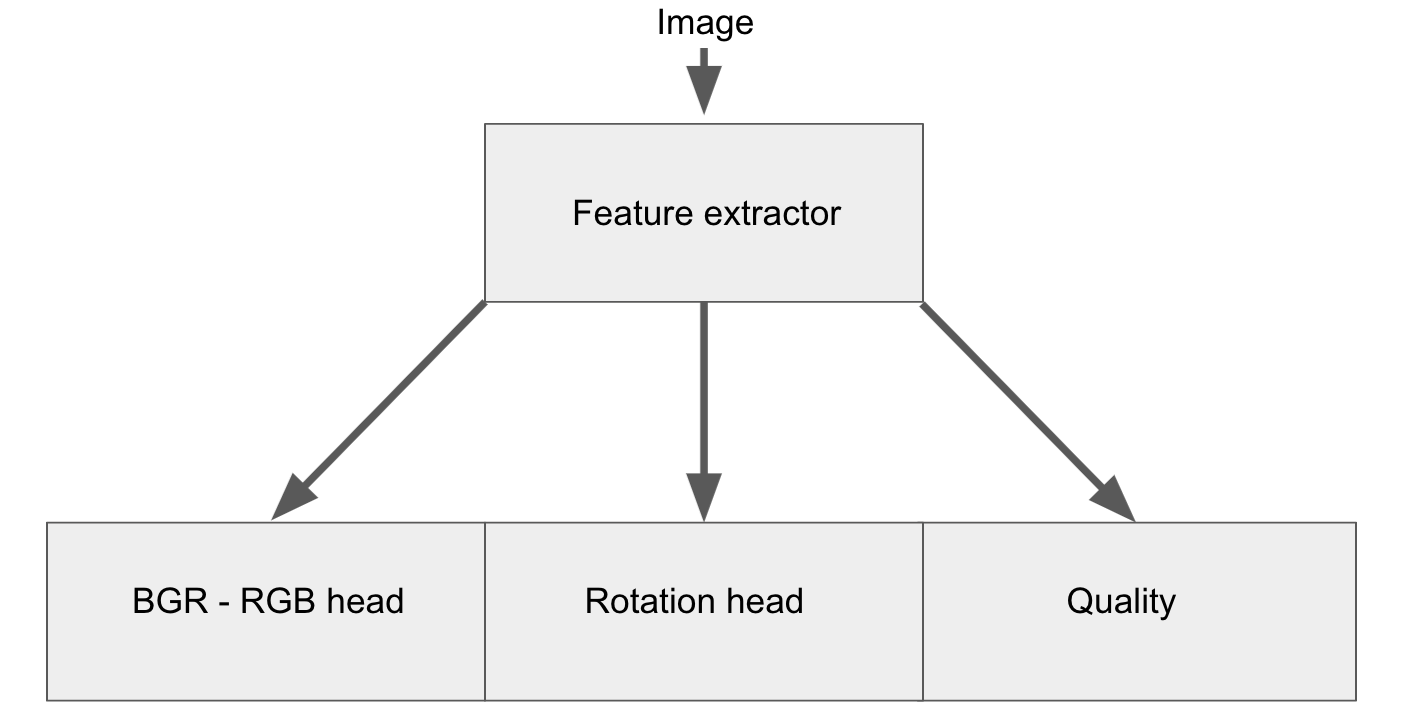

# На вход в классификатор подается изображение, на выходе должны быть вероятности для следующих классов:
### Выход качество: 

классы: 

1. Blur - фото смазано 

2. Torch -  фото засвечено

3. Sharp - фото хорошего качества, резкое

### Выход поворот:

классы: 

1. Поворот отсутствует 0 градусов

2. Поворот по часовой стрелке на 90 градусов

3. Поворот против часовой стрелке на 90 градусов

4. Перевернутое фото 180 градусов


### Выход  RGB-BGR:

классы:

1. RGB

2. BGR




 

## Особенности задания

1. Можно использовать любые открытые датасеты. Ниже найдете пример датасета.
2. Решение должно быть именно Вашим, уникальным и не повторяться с другими участниками.
4. Можно использовать любой удобный фреймворк (Pytorch, FastAI, Keras, Tensorflow)
5.Назовите папку для датасета DATASET_DIR в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset. Так мы сможем быстрее проверить решение


# Как начать


## Загрузка датасета с kaggle

In [ ]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

! pip install -q kaggle

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# example downloading dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.48G/1.49G [00:14<00:00, 129MB/s]
100% 1.49G/1.49G [00:14<00:00, 112MB/s]


Dataset was cloned after loading, remove extra dirs. And rename dir with dataset will be used.

In [ ]:
!mv /content/blur_dataset_scaled /content/a_arestov_images_dataset
!mv /content/a_arestov_images_dataset/defocused_blurred /content/a_arestov_images_dataset/blur 

# dataset was clone while downloading, so remove the duplicate
!rm -rf /content/defocused_blurred
!rm -rf /content/motion_blurred
!rm -rf /content/sharp

## Labels dict

In [ ]:
dataset_dict = {
    'quality': {0: 'blur',   1: 'torch',   2:'sharp'},
    'angle':   {0:  '0',     1: '90r',     2: '90l',   3: '180'}, 
    'format':  {0: 'bgr',    1: 'rgb'}
    #'format':  {0: 'rgb',    1: 'bgr'}
    }

## Seeds

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K

seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Prepare data

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.lib.display import join
import shutil 
from tqdm import tqdm
import os
from google.colab import files

## Resizing

In [ ]:
path = '/content/a_arestov_images_dataset/'

blur_path = path + 'blur/'
mot_blur_path = path + 'motion_blurred/'
sharp_path = path + 'sharp/'

def resize_dir(dir = blur_path, input_shape = (110,110)):
    for i, file_name in enumerate(tqdm(os.listdir(dir))):
        img = Image.open(dir+file_name).resize(input_shape)
        os.remove(dir+file_name)
        img.save(dir+file_name)

In [ ]:
# greater size exposes for instance drop due to RAM is over (while data normalization)
input_shape = (110,110) 
resize_dir(dir = blur_path, input_shape = input_shape)
resize_dir(dir = mot_blur_path, input_shape = input_shape)
resize_dir(dir = sharp_path, input_shape = input_shape)

100%|██████████| 350/350 [00:27<00:00, 12.54it/s]


## Example of image blending

**Summary**: i didn't manage to find any mention of sun glares or whatever applied in python, so i decided to blend sharp pictures and motion blur ones. Photos into dataset are triplet, so we can find pair 'sharp-mot_blur' for every picture (due to there are strictly 350 per triplet) with just sorting content of irs by name (fortunately, images have similar names).

Example is below. 

0_IPHONE-SE_M.JPG
0_IPHONE-SE_S.JPG


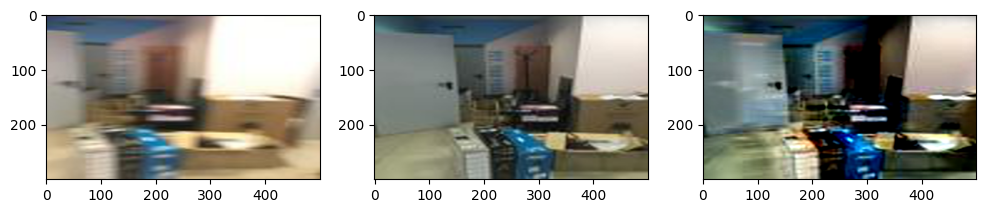

In [ ]:
n = 0
img1 = Image.open(mot_blur_path + \
                  str( sorted(os.listdir(mot_blur_path))[n] )).resize((500,300))
img2 = Image.open(sharp_path + \
                  str( sorted(os.listdir(sharp_path))[n] )).resize((500,300)) # normal sharp
img3 = Image.blend(img1, img2, 1.7)

print(sorted(os.listdir(mot_blur_path))[n])
print(sorted(os.listdir(sharp_path))[n])
fig, ax = plt.subplots(1,3, figsize=(12, 9))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3) # product

## Blending (create 'torched' images)

Expand the sample with 'torch' images:

In [ ]:
!mkdir /content/a_arestov_images_dataset/torch
!mkdir /content/models # for models are learned in future

In [ ]:
source_mot_blur = path + 'motion_blurred/'
source_sharp = path + 'sharp/'
source_torch = path + 'torch/'

for i, file_name in enumerate(tqdm(os.listdir(source_mot_blur))):
    name, extension = os.path.splitext(file_name)
    blure_img = Image.open(source_mot_blur + \
                  str( sorted(os.listdir(mot_blur_path))[i] ))
    sharp_img = Image.open(source_sharp + \
                  str( sorted(os.listdir(sharp_path))[i] )) # normal sharp
    torch_img = Image.blend(blure_img, sharp_img, 1.7) 
    
    # save and label images accoring 'torch' '0 deg' 'rgb'
    torch_img.save(f'{source_torch}/' + f'1_0_1_{i}'+f'{extension}') # torch 0deg rgb

100%|██████████| 350/350 [00:01<00:00, 342.61it/s]


In [ ]:
!rm -rf /content/a_arestov_images_dataset/motion_blurred
len(os.listdir(source_torch))

350

## Labelling

In [ ]:
def put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        os.rename(source_dir+'/'+file_name, f'{source_dir}/'+ f'{label}{i}'+f'{extension}') 

put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_')  # blur  0deg rgb
put_img_label(source_dir = os.path.join(path, 'sharp'), label = '2_0_1_') # sharp 0deg rgb

100%|██████████| 350/350 [00:00<00:00, 28871.05it/s]


In [ ]:
def rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1):
    r90r = img.rotate(-90)
    r90r.save(f'{source_dir}/' + f'{qual_label}_1_{encode_label}_{i}'+f'{extension}')
    r90l = img.rotate(90)
    r90l.save(f'{source_dir}/' + f'{qual_label}_2_{encode_label}_{i}'+f'{extension}')
    r180 = img.rotate(180)
    r180.save(f'{source_dir}/' + f'{qual_label}_3_{encode_label}_{i}'+f'{extension}')

In [ ]:
def augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        r, g, b = img.split()
        image_bgr = Image.merge("RGB", (b, g, r))
        image_bgr.save(f'{source_dir}/' + f'{qual_label}_0_0_{i}'+f'{extension}')

        rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1) # for RGB
        rot_aug(image_bgr, i, extension, source_dir, qual_label, encode_label = 0) # for BGR

In [ ]:
augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0')
augmentation(source_dir = os.path.join(path, 'sharp'), qual_label = '2')
augmentation(source_dir = os.path.join(path, 'torch'), qual_label = '1')

100%|██████████| 350/350 [00:01<00:00, 216.60it/s]


In [ ]:
print((len(os.listdir('/content/a_arestov_images_dataset/blur'))))
print((len(os.listdir('/content/a_arestov_images_dataset/sharp'))))
print((len(os.listdir('/content/a_arestov_images_dataset/torch'))))

2800
2800
2800


## Separating

In [ ]:
from IPython.lib.display import join
import numpy as np

!mkdir /content/a_arestov_images_dataset/train
!mkdir /content/a_arestov_images_dataset/valid
!mkdir /content/a_arestov_images_dataset/test

In [ ]:
# !rm -rf /content/a_arestov_images_dataset/train
# !rm -rf /content/a_arestov_images_dataset/valid
# !rm -rf /content/a_arestov_images_dataset/test

In [ ]:
train_x, train_y = [], []
valid_x, valid_y = [], []
test_x, test_y = [], []

In [ ]:
path = '/content/a_arestov_images_dataset/'
dirs = ['blur', 'sharp', 'torch']

train_dir = 'train'
val_dir = 'valid'
test_dir = 'test'

# separate in valid and train
for dir in dirs:
    source_dir = os.path.join(path, dir)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i%10 != 0:
            dest_dir = os.path.join(path+train_dir)
        else:
            dest_dir = os.path.join(path+val_dir)
            name, extension = os.path.splitext(file_name)
            image = np.asarray(Image.open(source_dir+'/'+file_name))
            valid_x.append(image)
            valid_y.append(name.split('_')[:3])
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

# separate in test and train 
source_dir = os.path.join(path, train_dir)
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    if i%8 == 0:
        name, extension = os.path.splitext(file_name)
        dest_dir = os.path.join(path+test_dir)
        image = np.asarray(Image.open(source_dir+'/'+file_name))
        test_x.append(image)
        test_y.append(name.split('_')[:3])
        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
    else:
        # pass (all below are to be erased)
        name, extension = os.path.splitext(file_name)
        image = np.asarray(Image.open(source_dir+'/'+file_name))
        train_x.append(image)
        train_y.append(name.split('_')[:3])

train_x, train_y = np.array(train_x), np.array(train_y).astype(np.int32)
valid_x, valid_y = np.array(valid_x), np.array(valid_y).astype(np.int32)
test_x, test_y = np.array(test_x), np.array(test_y).astype(np.int32)

100%|██████████| 7560/7560 [00:03<00:00, 2267.96it/s]


In [ ]:
print('Train shapes: ', train_x.shape, train_y.shape)
print('Valid shapes: ', valid_x.shape, valid_y.shape)
print('Test shapes: ', test_x.shape, test_y.shape)

Train shapes:  (6615, 110, 110, 3) (6615, 3)
Valid shapes:  (840, 110, 110, 3) (840, 3)
Test shapes:  (945, 110, 110, 3) (945, 3)


## Data normalization & labeling

In [ ]:
train_x = train_x / 255.0
valid_x = valid_x / 255.0
test_x = test_x / 255.0

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

def binarize_labels(sample):
    lb_quan = LabelBinarizer()
    quan = lb_quan.fit_transform(sample.T[0])
    lb_rot = LabelBinarizer()
    rot = lb_rot.fit_transform(sample.T[1])
    lb_col = LabelBinarizer()
    color = lb_col.fit_transform(sample.T[2]) 
    return quan, rot, color

In [ ]:
train_quan, train_rot, train_color = binarize_labels(train_y)
valid_quan, valid_rot, valid_color = binarize_labels(valid_y)
test_quan, test_rot, test_color = binarize_labels(test_y)

# Keras model (large)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout 
from keras.layers import Flatten, Lambda, Input, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2

%config InlineBackend.figure_format = 'svg'

## Topology

In [ ]:
input_shape = (110, 110, 3)
inputs = Input(shape = input_shape)

### Quality branch

In [ ]:
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
cat = BatchNormalization()(cat)
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Flatten()(cat)
cat = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Dropout(0.5)(cat)
cat = Dense(train_quan.shape[1], activation = 'softmax', name = 'cat')(cat)

### Rotation branch

In [ ]:
rot = Lambda(lambda z: tf.image.rgb_to_grayscale(z))(inputs)
rot = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization(axis = -1)(rot)
rot = MaxPooling2D(3)(rot)
rot = Dropout(0.25)(rot)

rot = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization(axis = -1)(rot)
rot = MaxPooling2D()(rot)
rot = Dropout(0.25)(rot)

rot = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization(axis = -1)(rot)
rot = MaxPooling2D()(rot)
rot = Dropout(0.25)(rot)

rot = Flatten()(rot)
rot = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization()(rot)
rot = Dropout(0.5)(rot)
rot = Dense(train_rot.shape[1], activation = 'softmax', name = 'rot')(rot)

### Color branch

In [ ]:
col = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D(3)(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Flatten()(col)
col = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization()(col)
col = Dropout(0.5)(col)
col = Dense(train_color.shape[1], activation = 'sigmoid', name = 'col')(col)

## Learning

In [ ]:
# upload 'best_model_large.hdf5' to check the best or learn again (optionally below)

In [ ]:
model = Model(inputs = inputs, outputs = [cat, rot, col]) 
losses = {'cat': 'categorical_crossentropy',
          'rot': 'categorical_crossentropy',
          'col': tf.keras.losses.BinaryCrossentropy()}

loss_weights = {'cat': 1.0, 'rot': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('/content/models/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')

model.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])

history = model.fit(train_x, {'cat': train_quan, 'rot': train_rot, 'col': train_color},
                    validation_data = (valid_x, {'cat': valid_quan, 'rot': valid_rot, 'col': valid_color}),
                    batch_size = 10, epochs = 10, callbacks = [checkpoint])

Epoch 1/10
662/662 [==============================] - ETA: 0s - loss: 3.1635 - cat_loss: 0.9955 - rot_loss: 1.5495 - col_loss: 0.6185 - cat_accuracy: 0.5599 - rot_accuracy: 0.3991 - col_accuracy: 0.7066
Epoch 1: val_loss improved from inf to 2.76610, saving model to /content/models/best_model.hdf5
662/662 [==============================] - 49s 37ms/step - loss: 3.1635 - cat_loss: 0.9955 - rot_loss: 1.5495 - col_loss: 0.6185 - cat_accuracy: 0.5599 - rot_accuracy: 0.3991 - col_accuracy: 0.7066 - val_loss: 2.7661 - val_cat_loss: 0.9281 - val_rot_loss: 1.3152 - val_col_loss: 0.5228 - val_cat_accuracy: 0.5607 - val_rot_accuracy: 0.4690 - val_col_accuracy: 0.7762
Epoch 2/10
662/662 [==============================] - ETA: 0s - loss: 2.5459 - cat_loss: 0.7768 - rot_loss: 1.2444 - col_loss: 0.5247 - cat_accuracy: 0.6428 - rot_accuracy: 0.4650 - col_accuracy: 0.7554
Epoch 2: val_loss did not improve from 2.76610
662/662 [==============================] - 23s 34ms/step - loss: 2.5459 - cat_loss: 

## Plot history

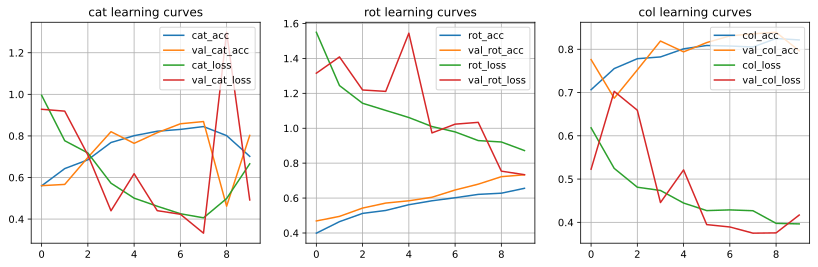

In [ ]:
H = history.history
fig = plt.figure(figsize = (14, 4))

for i, c in enumerate(('cat', 'rot', 'col')):

    plt.subplot(int(f'13{i+1}'))
    plt.plot(H[f'{c}_accuracy'], label = f'{c}_acc')
    plt.plot(H[f'val_{c}_accuracy'], label = f'val_{c}_acc')
    plt.plot(H[f'{c}_loss'], label = f'{c}_loss')
    plt.plot(H[f'val_{c}_loss'], label = f'val_{c}_loss')
    plt.title(f'{c} learning curves')
    plt.legend(loc = 'upper right')
    plt.grid()

## Check predddictions

Obviously, model above is overfitted. And a series of experiment told, that net's topology is too complicated. 
But in the same time i managed to get one with satisfactory results (f1 about 0.9 and more).

### (**RECOMMEND !!!**) In case you upload the model 'best_model_large.hdf5'

In [ ]:
model2 = Model(inputs = inputs, outputs = [cat, rot, col]) 
losses = {'cat': 'categorical_crossentropy',
          'rot': 'categorical_crossentropy',
          'col': tf.keras.losses.BinaryCrossentropy()}

loss_weights = {'cat': 1.0, 'rot': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('/content/models/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')

model2.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])

In [ ]:
model2.load_weights('/content/models/best_model_large.hdf5') # i will also send file with the best model
qual_preds, rot_preds, col_preds = model2.predict(test_x)

qual_preds = np.argmax(qual_preds, axis = 1)
rot_preds = np.argmax(rot_preds, axis = 1)
col_preds = col_preds.round().astype(np.int32)

30/30 [==============================] - 1s 21ms/step


### Predict by current net (without uploading) (if uploaded, skip this section)

In [ ]:
qual_preds, rot_preds, col_preds = model.predict(test_x)

qual_preds = np.argmax(qual_preds, axis = 1)
rot_preds = np.argmax(rot_preds, axis = 1)
col_preds = col_preds.round().astype(np.int32)

### Confusion matrix

In [ ]:
# Creating confusion matrices
qual_confusion = confusion_matrix(np.argmax(test_quan, axis = 1), qual_preds)
rot_confusion = confusion_matrix(np.argmax(test_rot, axis = 1), rot_preds)
col_confusion = confusion_matrix(test_color.flatten(), col_preds.flatten())

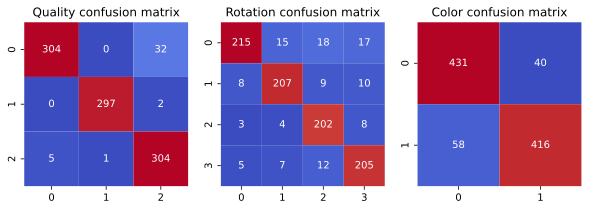

In [ ]:
confusions = [qual_confusion, rot_confusion, col_confusion]
labels_list = [[0,1,2], [0,1,2,3], [0,1]] # [quan_labels, rot_labels, col_labels]
fig = plt.figure(figsize = (10, 6))
titles = ['Quality', 'Rotation', 'Color']
for i in range(3):
    plt.subplot(int(f'13{i+1}'))
    label_lst = labels_list[i]
    sns.heatmap(confusions[i], square = True, annot = True, fmt = 'd', cbar = False, 
                xticklabels = label_lst, yticklabels = label_lst, cmap = 'coolwarm').set_title(f'{titles[i]} confusion matrix')

In [ ]:
print('F1 for quality: ', round( f1_score(np.argmax(test_quan, axis=1), qual_preds, average='weighted'), 3))
print('F1 for rotation: ', round( f1_score(np.argmax(test_rot, axis=1), rot_preds, average='weighted'), 3))
print('F1 for color code: ', round( f1_score(test_color, col_preds, average='binary'), 3))

F1 for quality:  0.958
F1 for rotation:  0.877
F1 for color code:  0.895


# Keras model (small)

In [ ]:
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout 
from keras.layers import Flatten, Lambda, Input, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2

%config InlineBackend.figure_format = 'svg'

## Topology

In [ ]:
input_shape = (110, 110, 3)
inputs = Input(shape = input_shape)

### Quality branch

In [ ]:
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
cat = BatchNormalization()(cat)
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Flatten()(cat)
cat = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Dropout(0.5)(cat)
cat = Dense(train_quan.shape[1], activation = 'softmax', name = 'cat')(cat)

### Rotation branch

In [ ]:
rot = Lambda(lambda z: tf.image.rgb_to_grayscale(z))(inputs)
rot = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization(axis = -1)(rot)
rot = MaxPooling2D(3)(rot)
rot = Dropout(0.25)(rot)

rot = Flatten()(rot)
rot = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(rot)
rot = BatchNormalization()(rot)
rot = Dropout(0.5)(rot)
rot = Dense(train_rot.shape[1], activation = 'softmax', name = 'rot')(rot)

### Color branch

In [ ]:
col = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D(3)(col)
col = Dropout(0.25)(col)

# col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
# col = BatchNormalization(axis = -1)(col)
# col = MaxPooling2D()(col)
# col = Dropout(0.25)(col)

col = Flatten()(col)
col = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization()(col)
col = Dropout(0.5)(col)
col = Dense(train_color.shape[1], activation = 'sigmoid', name = 'col')(col)

## Learning

Thats better to learn model are lighter.

In [ ]:
# upload 'best_model_small.hdf5' to check the best or learn again

In [ ]:
model_light = Model(inputs = inputs, outputs = [cat, rot, col]) 
losses = {'cat': 'categorical_crossentropy',
          'rot': 'categorical_crossentropy',
          'col': tf.keras.losses.BinaryCrossentropy()}

loss_weights = {'cat': 1.0, 'rot': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('/content/models/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')

model_light.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])

history = model_light.fit(train_x, {'cat': train_quan, 'rot': train_rot, 'col': train_color},
                    validation_data = (valid_x, {'cat': valid_quan, 'rot': valid_rot, 'col': valid_color}),
                    batch_size = 15, epochs = 15, callbacks = [checkpoint])

Epoch 1/15
440/441 [============================>.] - ETA: 0s - loss: 3.2003 - cat_loss: 1.0717 - rot_loss: 1.4590 - col_loss: 0.6696 - cat_accuracy: 0.5700 - rot_accuracy: 0.4664 - col_accuracy: 0.7133
Epoch 1: val_loss improved from inf to 2.84220, saving model to /content/models/best_model.hdf5
441/441 [==============================] - 26s 41ms/step - loss: 3.1991 - cat_loss: 1.0711 - rot_loss: 1.4586 - col_loss: 0.6693 - cat_accuracy: 0.5704 - rot_accuracy: 0.4662 - col_accuracy: 0.7134 - val_loss: 2.8422 - val_cat_loss: 1.3530 - val_rot_loss: 0.9854 - val_col_loss: 0.5038 - val_cat_accuracy: 0.4202 - val_rot_accuracy: 0.6310 - val_col_accuracy: 0.7702
Epoch 2/15
440/441 [============================>.] - ETA: 0s - loss: 2.0668 - cat_loss: 0.6870 - rot_loss: 0.8686 - col_loss: 0.5112 - cat_accuracy: 0.7017 - rot_accuracy: 0.6662 - col_accuracy: 0.7665
Epoch 2: val_loss improved from 2.84220 to 1.75405, saving model to /content/models/best_model.hdf5
441/441 [======================

## Plot history

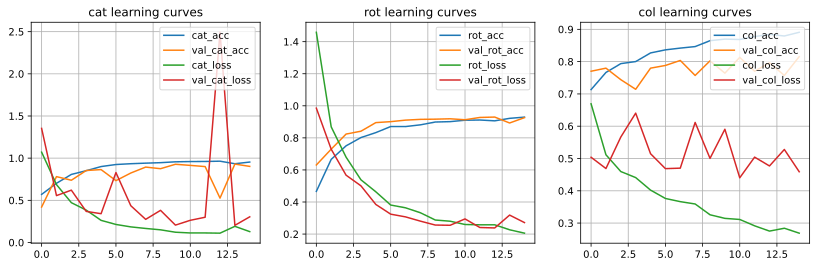

In [ ]:
H = history.history
fig = plt.figure(figsize = (14, 4))

for i, c in enumerate(('cat', 'rot', 'col')):

    plt.subplot(int(f'13{i+1}'))
    plt.plot(H[f'{c}_accuracy'], label = f'{c}_acc')
    plt.plot(H[f'val_{c}_accuracy'], label = f'val_{c}_acc')
    plt.plot(H[f'{c}_loss'], label = f'{c}_loss')
    plt.plot(H[f'val_{c}_loss'], label = f'val_{c}_loss')
    plt.title(f'{c} learning curves')
    plt.legend(loc = 'upper right')
    plt.grid()

In [ ]:
history = model_light.fit(train_x, {'cat': train_quan, 'rot': train_rot, 'col': train_color},
                    validation_data = (valid_x, {'cat': valid_quan, 'rot': valid_rot, 'col': valid_color}),
                    batch_size = 15, epochs = 5, callbacks = [checkpoint])

Epoch 1/5
441/441 [==============================] - ETA: 0s - loss: 0.5619 - cat_loss: 0.1024 - rot_loss: 0.2088 - col_loss: 0.2506 - cat_accuracy: 0.9646 - rot_accuracy: 0.9271 - col_accuracy: 0.8971
Epoch 1: val_loss improved from 0.99773 to 0.83218, saving model to /content/models/best_model.hdf5
441/441 [==============================] - 15s 33ms/step - loss: 0.5619 - cat_loss: 0.1024 - rot_loss: 0.2088 - col_loss: 0.2506 - cat_accuracy: 0.9646 - rot_accuracy: 0.9271 - col_accuracy: 0.8971 - val_loss: 0.8322 - val_cat_loss: 0.1583 - val_rot_loss: 0.2286 - val_col_loss: 0.4452 - val_cat_accuracy: 0.9476 - val_rot_accuracy: 0.9405 - val_col_accuracy: 0.8226
Epoch 2/5
441/441 [==============================] - ETA: 0s - loss: 0.5189 - cat_loss: 0.0824 - rot_loss: 0.1977 - col_loss: 0.2387 - cat_accuracy: 0.9711 - rot_accuracy: 0.9320 - col_accuracy: 0.9022
Epoch 2: val_loss did not improve from 0.83218
441/441 [==============================] - 14s 31ms/step - loss: 0.5189 - cat_loss

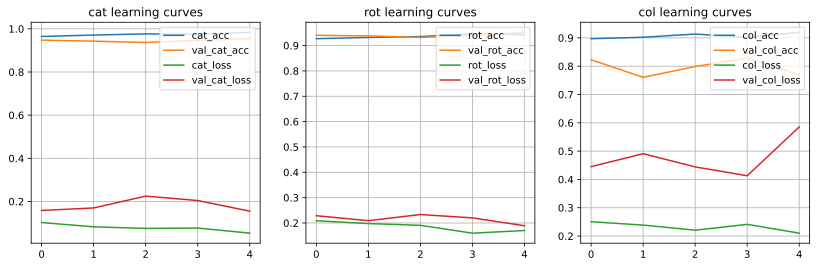

In [ ]:
H = history.history
fig = plt.figure(figsize = (14, 4))

for i, c in enumerate(('cat', 'rot', 'col')):

    plt.subplot(int(f'13{i+1}'))
    plt.plot(H[f'{c}_accuracy'], label = f'{c}_acc')
    plt.plot(H[f'val_{c}_accuracy'], label = f'val_{c}_acc')
    plt.plot(H[f'{c}_loss'], label = f'{c}_loss')
    plt.plot(H[f'val_{c}_loss'], label = f'val_{c}_loss')
    plt.title(f'{c} learning curves')
    plt.legend(loc = 'upper right')
    plt.grid()

**Resume:** overfitting is decreased in comparison with 'large' models.

## Check predddictions

### Upload the best model of current topology in session ('best_model.hdf5')

In [ ]:
model_light2 = Model(inputs = inputs, outputs = [cat, rot, col]) 
losses = {'cat': 'categorical_crossentropy',
          'rot': 'categorical_crossentropy',
          'col': tf.keras.losses.BinaryCrossentropy()}

loss_weights = {'cat': 1.0, 'rot': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('/content/models/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')

model_light2.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])

In [ ]:
model_light2.load_weights('/content/models/best_model.hdf5') # i will also send file with the best model
qual_preds, rot_preds, col_preds = model_light2.predict(test_x)

qual_preds = np.argmax(qual_preds, axis = 1)
rot_preds = np.argmax(rot_preds, axis = 1)
col_preds = col_preds.round().astype(np.int32)

30/30 [==============================] - 1s 14ms/step


### Confusion matrix

In [ ]:
# Creating confusion matrices
qual_confusion = confusion_matrix(np.argmax(test_quan, axis = 1), qual_preds)
rot_confusion = confusion_matrix(np.argmax(test_rot, axis = 1), rot_preds)
col_confusion = confusion_matrix(test_color.flatten(), col_preds.flatten())

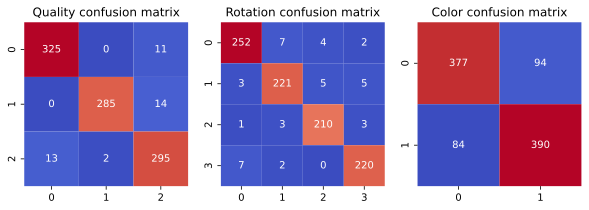

In [ ]:
confusions = [qual_confusion, rot_confusion, col_confusion]
labels_list = [[0,1,2], [0,1,2,3], [0,1]] # [quan_labels, rot_labels, col_labels]
fig = plt.figure(figsize = (10, 6))
titles = ['Quality', 'Rotation', 'Color']
for i in range(3):
    plt.subplot(int(f'13{i+1}'))
    label_lst = labels_list[i]
    sns.heatmap(confusions[i], square = True, annot = True, fmt = 'd', cbar = False, 
                xticklabels = label_lst, yticklabels = label_lst, cmap = 'coolwarm').set_title(f'{titles[i]} confusion matrix')

In [ ]:
print('F1 for quality: ', round( f1_score(np.argmax(test_quan, axis=1), qual_preds, average='weighted'), 3))
print('F1 for rotation: ', round( f1_score(np.argmax(test_rot, axis=1), rot_preds, average='weighted'), 3))
print('F1 for color code: ', round( f1_score(test_color, col_preds, average='binary'), 3))

F1 for quality:  0.958
F1 for rotation:  0.956
F1 for color code:  0.814


# Пример датасета 
https://www.kaggle.com/kwentar/blur-dataset









































































































# Контакты

Вопросы можно задать в 
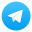


@JI_411

@dragynir


Удачи в выполнении задания!